In [1]:
!pip install keras tqdm

In [2]:
import numpy as np
np.random.seed(0)

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

import keras.backend as K
from keras.layers import Activation, Input

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('classic')


Using TensorFlow backend.


### Loading data (Olivetti faces)

In [0]:
data_obj = fetch_olivetti_faces()

X = data_obj['data']
X = 1.0 * (X > X.mean())

y = data_obj['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=0)

### RBM definitions

RBMs are undirected graphical models with the following structure ($h_i, v_j$ are binary):

<p align="center"><img src="http://40.media.tumblr.com/5e4a23b85f61e2aaeeb1188c2e35536a/tumblr_inline_npz2ev1m5Y1rnd3q0_540.png" /></p>

The joint probability is given by:
$$E(v, h) = vWh$$

$$P(v, h) = \frac{e^{-E(v, h)}}{Z}$$

($Z$ is a normalizing factor, $Z = \sum_{u, g}e^{-E(u, g)}$)

That means that $$P(h|v) = \prod_{i}P(h_i|v)$$ and consequently from the definition it follows that $$P(h_i = 1 \mid v) = \frac{1}{1 + exp((vW)_{i})}$$

RBMs are optimized using approximation to likelihood.

$$P(x) = \frac{\sum_{h}P(x, h)}{Z}$$

The algorithm that is used to approximate derivatives of log likelihood is called **contrastive divergence**, see for example [this link](http://deeplearning.net/tutorial/rbm.html).

In [0]:
def probabilities_from_other(W, other):
  """
  Get probabilities from hidden given visible or the other way around
  """
  energy = K.dot(other, W)
  return K.sigmoid(energy)


def sample_bernoulli(probas):
  uniform_samples = K.random_uniform(shape=K.shape(probas))
  bernoulli_samples = K.greater(
    probas,
    uniform_samples
  )
  return K.cast(bernoulli_samples, K.floatx())


def sample_from_other(W, other):
  """
  Sample hidden given visible or the other way around
  """
  proba = probabilities_from_other(W, other)
  return sample_bernoulli(proba)


def configuration_goodness_gradient(visible, hidden):
  """
  Gradient of (negative) energy 
  """
  n_samples_norm = K.cast(1 / K.shape(visible)[0], K.floatx())
  return - n_samples_norm * K.dot(
      K.transpose(visible),
      hidden,
  )


def cd1_variables(W, visible):
  hidden0 = K.identity(
      sample_from_other(W, visible),
      name='hidden0')
  
  visible_proba1 = probabilities_from_other(K.transpose(W), hidden0)
  visible1 = K.identity(
      sample_bernoulli(visible_proba1),
      name='visible1')
  
  hidden1 = K.identity(
      probabilities_from_other(W, visible1),
      name='hidden1')

  return hidden0, visible1, hidden1


def cd1(W, visible):
  hidden0, visible1, hidden1 = cd1_variables(W, visible)
  goodness_gradient0 = configuration_goodness_gradient(visible, hidden0)
  goodness_gradient1 = configuration_goodness_gradient(visible1, hidden1)
  
  return goodness_gradient0 - goodness_gradient1

#### Plotting utils

In [0]:
def show_reconstruction(original, reconstructed, howmany=5):
  for i in range(howmany):
    test_face = original[i].reshape(64, 64)
    reconstructed_face = reconstructed[i].reshape(64, 64) 

    plt.figure(1)
    plt.subplot(221)
    plt.imshow(test_face, cmap='gray')
    plt.title('original')
    plt.axis('off')
    plt.subplot(222)
    plt.imshow(reconstructed_face, cmap='gray')
    plt.title('reconstructed')
    plt.axis('off')
    plt.show()

In [0]:
n_visible = X_train.shape[1]
n_hidden = 500

W_in = K.variable(np.random.uniform(low=-2 / np.sqrt(n_hidden), high=2 / np.sqrt(n_hidden), size=(n_visible, n_hidden)))
visible_shape = (n_visible,)
visible_in = Input(shape=visible_shape)

cd = cd1(W_in, visible_in)

### RBM setup

In [0]:
lr = 0.02

train_op = K.function(
    inputs=[visible_in],
    outputs=[cd],
    updates=[
        K.update(W_in, W_in - lr *cd)
    ]
)

In [8]:
print(K.eval(W_in))

[[ 0.00873202  0.03849424  0.01838287 ... -0.01758202 -0.04500517
   0.00104941]
 [-0.03392011 -0.02271221  0.00446685 ...  0.07842553 -0.04854118
   0.03168797]
 [ 0.01661493 -0.08764247 -0.00432434 ... -0.06936283 -0.08186441
  -0.04870317]
 ...
 [-0.06972324 -0.05617766  0.0522058  ...  0.03802041  0.07064375
  -0.06629859]
 [ 0.01711429 -0.05858089  0.04831056 ...  0.00885926 -0.07163104
   0.0577798 ]
 [ 0.04525103  0.05784644 -0.05484731 ... -0.05663916  0.0747067
   0.07731473]]


In [9]:
%%time

minibatch_size = 32
n_epochs = 500
_n_batches = int(round(X_train.shape[0] / minibatch_size))

for __ in tqdm(range(n_epochs)):
  for i in range(_n_batches):
    minibatch_indices = np.random.randint(X_train.shape[0], size=minibatch_size)
    minibatch = X_train[minibatch_indices]
    train_op([minibatch])

100%|██████████| 500/500 [00:23<00:00, 21.11it/s]

CPU times: user 17.9 s, sys: 5.42 s, total: 23.4 s
Wall time: 23.7 s


In [10]:
print(K.eval(W_in))

[[ 0.11111689  0.14757147  0.02778305 ...  0.03015902 -0.23130675
   0.05327657]
 [ 0.05523432  0.0392649   0.05664799 ...  0.10390357 -0.23841698
  -0.08131589]
 [ 0.12375063 -0.22021306  0.15128508 ... -0.04269677 -0.29122007
  -0.28616464]
 ...
 [-0.12119016  0.32286543  0.06820793 ...  0.05073078  0.16097711
   0.11162882]
 [ 0.01093323  0.38586944  0.15212335 ... -0.10209196 -0.12231029
   0.35373405]
 [ 0.12772928  0.25844872  0.12722252 ... -0.07767712  0.2323753
   0.32649502]]


In [0]:
sample_hidden_from_visible = K.function(
  inputs=[visible_in],
  outputs=[sample_from_other(W_in, visible_in)]
)

hidden_input = Input(shape=(n_hidden,))
sample_visible_from_hidden = K.function(
  inputs=[hidden_input],
  outputs=[sample_from_other(K.transpose(W_in), hidden_input)]
)

In [0]:
[sampled_visible_test] = sample_visible_from_hidden(sample_hidden_from_visible([X_test]))
[sampled_visible_train] = sample_visible_from_hidden(sample_hidden_from_visible([X_train]))

### Show reconstructed faces

#### Reconstructed train faces

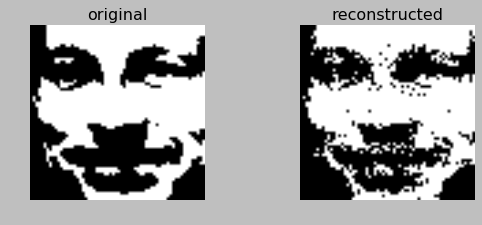

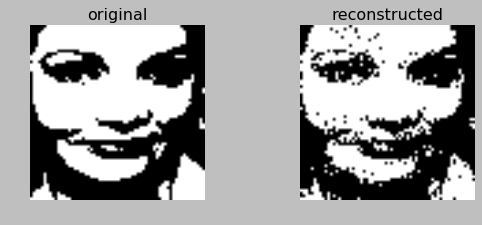

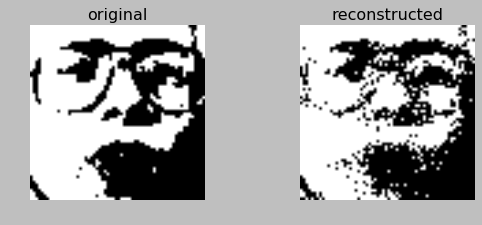

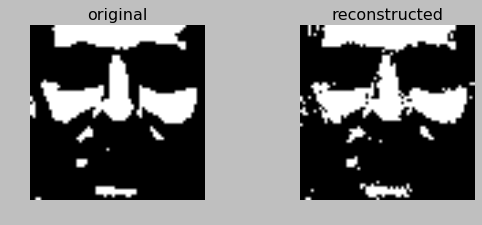

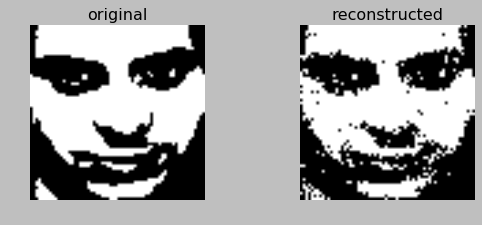

In [13]:
show_reconstruction(X_train, sampled_visible_train)

#### Reconstructed test faces

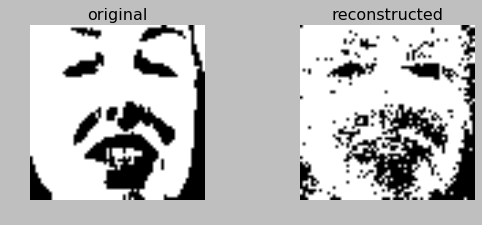

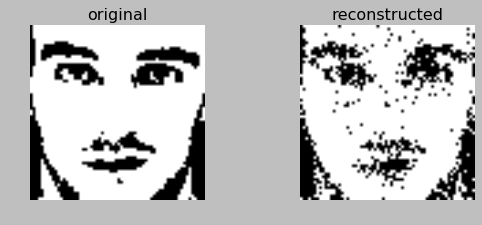

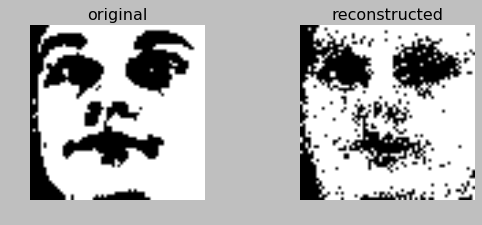

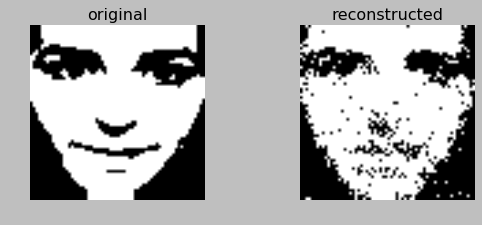

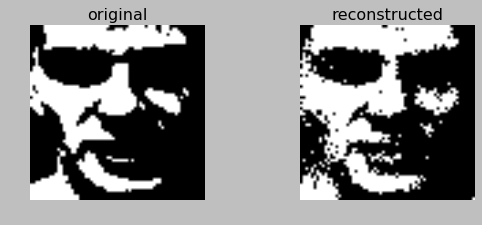

In [14]:
show_reconstruction(X_test, sampled_visible_test)